In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.math import maximum as tfmax
import tensorflow as tf
import ysnnutil as yut

2023-06-14 06:58:41.187946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-14 06:58:41.188015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
def pwAct2(x):
    return x*x
nnHom=2
nun=4
model=keras.Sequential([
layers.Dense(nun,activation=pwAct2),
layers.Dense(1,)
])
mPath='./nb02_fitHill'
model.load_weights(mPath, skip_mismatch=False, by_name=False, options=None)

In [15]:
### Aluminum alloy AA6022-T4 r-values: r0=0.8; r45=0.37; r90=0.54
a1,a2,a3=yut.paramHill([0.8,0.37,0.54])

i =  0  sxy =  0.0
i =  1  sxy =  0.12913266227921802
i =  2  sxy =  0.19369899341882704
i =  3  sxy =  0.25826532455843604
i =  4  sxy =  0.32283165569804506
i =  5  sxy =  0.3873979868376541
i =  6  sxy =  0.45196431797726305
i =  7  sxy =  0.5165306491168721
i =  8  sxy =  0.5810969802564812
i =  9  sxy =  0.6295217286111878
i =  10  sxy =  0.6392066782821292
i =  11  sxy =  0.6443719847732979


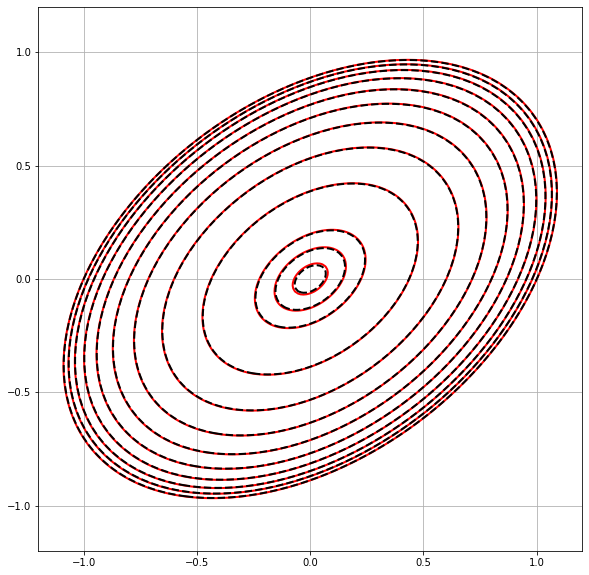

In [16]:
npt=200
vsx=np.linspace(-1.2,1.2,npt)
vsy=np.linspace(-1.2,1.2,npt)
maxSXY=1.0/np.sqrt(a3)
#vsxy=[0.0]
vsxy=maxSXY*np.array([0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.975,0.99,0.998])
X,Y=np.meshgrid(vsx,vsy)
X,Y=X.reshape((npt*npt,1)),Y.reshape((npt*npt,1))
vp=np.zeros((npt*npt,3))
vp[:,0]=X[:,0];vp[:,1]=Y[:,0]
fg2=plt.figure(figsize=(10,10))
ax2=fg2.add_subplot()
for ii,sxy in enumerate(vsxy):
    vp[:,2]=sxy
    vz=model(vp)
    vzHill=yut.ysHill(vp[:,0],vp[:,1],vp[:,2],a1,a2,a3)
    print('i = ',ii, ' sxy = ',sxy)
    ax2.contour(vsx,vsy,tf.reshape(vz,(npt,npt)),levels=[1.0],linewidths=2,colors=['r'])
    ax2.contour(vsx,vsy,vzHill.reshape((npt,npt)),levels=[1.0],linewidths=2,linestyles='--',colors=['k'])
ax2.grid()
ax2.set_aspect('equal')
plt.show()

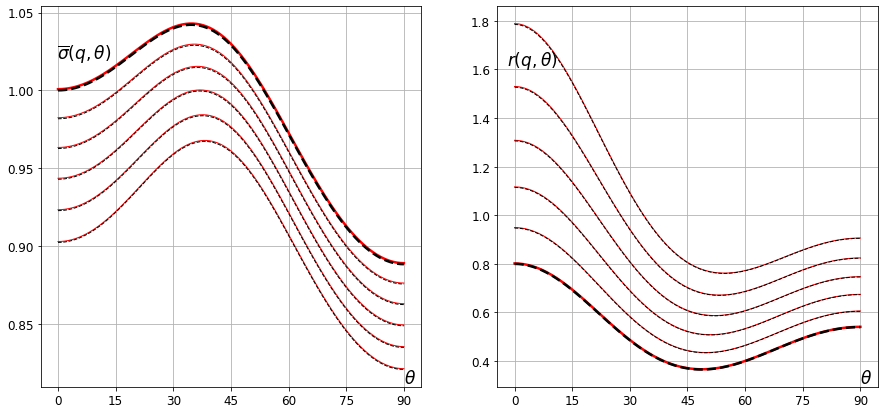

In [17]:
##Check directional predictions 
Nq=6
vq=np.linspace(0,-0.2,Nq) ###; print(vq)
vLW=np.ones(Nq);vLW[0]=2.5
Nphi=101
vphi=np.linspace(0,np.pi/2,Nphi);vDegs=180.0*(vphi/np.pi)
vcos=np.cos(vphi);vsin=np.sin(vphi)
vcos2,vsin2,vsc=vcos*vcos,vsin*vsin,vcos*vsin
#vsx,vsy,vsxy=np.zeros(Nphi),np.zeros(Nphi),np.zeros(Nphi)
vS,vR, mxS,mnS = np.zeros(Nphi),np.zeros(Nphi), -1.0, 100.0
vSnn,vRnn = np.zeros(Nphi),np.zeros(Nphi)
linestyle1,linestyle2='--','-'
fg=plt.figure(figsize=(15,7))
ax1=fg.add_subplot(1,2,1)
ax2=fg.add_subplot(1,2,2)
for kq in range(Nq):
    q=vq[kq]
    for k in range(Nphi):
        vsx=vcos2[k]+q*vsin2[k]
        vsy=vsin2[k]+q*vcos2[k]
        vsxy=(1.0-q)*vsc[k]
        yf,[vDX,vDY,vDXY]=yut.fGYF_Hill(vsx,vsy,vsxy,[a1,a2,a3])            
        vR[k]=(vDXY*vsc[k]-vDX*vsin2[k]-vDY*vcos2[k])/(vDX+vDY)
        vS[k]=1.0/yf
        vp=np.array([vsx,vsy,vsxy]).reshape((1,3))
        x = tf.convert_to_tensor(vp, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x)
            yf = model(x)
        vSnn[k]=1.0/yf**(1.0/nnHom)  
        ##print(tape.gradient(yf, x))
        vDX,vDY,vDXY = tape.gradient(yf, x)[0]
        vRnn[k]=(vDXY*vsc[k]-vDX*vsin2[k]-vDY*vcos2[k])/(vDX+vDY)
    ax2.plot(vDegs,vRnn,linestyle=linestyle2,linewidth=vLW[kq],color='r')
    ax2.plot(vDegs,vR,linestyle=linestyle1,linewidth=vLW[kq],color='k')
    ax1.plot(vDegs,vSnn,linestyle=linestyle2,linewidth=vLW[kq],color='r')
    ax1.plot(vDegs,vS,linestyle=linestyle1,linewidth=vLW[kq],color='k')
thetaTicks=[0,15,30,45,60,75,90]
thetaLabels=['0','15','30','45','60','75','90']
ax1.set_xticks(thetaTicks,minor=False)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True)
ax2.set_xticks(thetaTicks,minor=False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True)
y1,y2=ax2.get_ylim()
ax2.text(90,y1+0.01*(y2-y1),r'$\theta$',fontsize=17)
ax2.text(-2,1.62,r'$r(q,\theta)$',fontsize=17)
y1,y2=ax1.get_ylim()
ax1.text(90,y1+0.01*(y2-y1),r'$\theta$',fontsize=17)
ax1.text(-0.2,1.02,r'$\overline{\sigma}(q,\theta)$',fontsize=17)
#fg.savefig('./nb01_Sigma_Rval.png',bbox_inches='tight',dpi=300)
#fg.savefig('./NN_Sigma_Rval.png',dpi=300)
plt.show()

In [18]:
### numerical estimates (Euclidean distances) of the approximation of the directional properties
Nq=6
vq=np.linspace(0,-0.2,Nq) 
Nphi=14
vphi=np.linspace(0,np.pi/2,Nphi);vDegs=180.0*(vphi/np.pi)
vcos=np.cos(vphi);vsin=np.sin(vphi)
vcos2,vsin2,vsc=vcos*vcos,vsin*vsin,vcos*vsin
vS,vR = np.zeros(Nphi),np.zeros(Nphi)
vSnn,vRnn = np.zeros(Nphi),np.zeros(Nphi)
for kq in range(Nq):
    q=vq[kq]
    for k in range(Nphi):
        vsx=vcos2[k]+q*vsin2[k]
        vsy=vsin2[k]+q*vcos2[k]
        vsxy=(1.0-q)*vsc[k]
        yf,[vDX,vDY,vDXY]=yut.fGYF_Hill(vsx,vsy,vsxy,[a1,a2,a3])            
        vR[k]=(vDXY*vsc[k]-vDX*vsin2[k]-vDY*vcos2[k])/(vDX+vDY)
        vS[k]=1.0/yf
        vp=np.array([vsx,vsy,vsxy]).reshape((1,3))
        x = tf.convert_to_tensor(vp, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x)
            yf = model(x)
        vSnn[k]=1.0/yf**(1.0/nnHom)  
        ##print(tape.gradient(yf, x))
        vDX,vDY,vDXY = tape.gradient(yf, x)[0]
        vRnn[k]=(vDXY*vsc[k]-vDX*vsin2[k]-vDY*vcos2[k])/(vDX+vDY)
deltaS=(vS-vSnn)**2
deltaS=np.sqrt(np.sum(deltaS))
deltaR=(vR-vRnn)**2
deltaR=np.sqrt(np.sum(deltaR))
print('deltaS = ',deltaS,'\ndeltaR = ',deltaR)

deltaS =  0.0022851106984331385 
deltaR =  0.008750466867639249


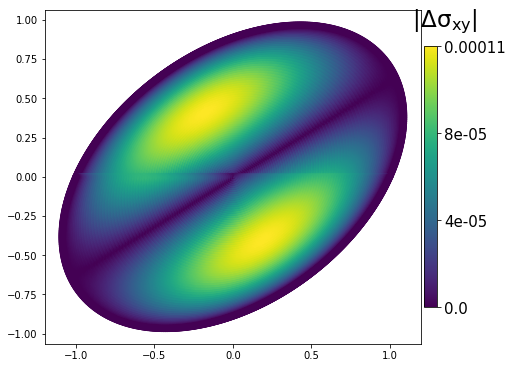

In [19]:
### Check the orthotropic symmetry gap
vp=yut.genSpherePointsTop(300).astype(np.float32)
yf=model(vp);rhoA=1.0/yf**(1.0/nnHom)
vp[:,2]=-vp[:,2]
yf=model(vp);rhoB=1.0/yf**(1.0/nnHom)
drho=np.abs((rhoA[:,0]-rhoB[:,0])*(-vp[:,2]))
fgg=plt.figure(figsize=(8,8))
axx=fgg.add_subplot()
axx.set_aspect('equal')
spl=axx.scatter(rhoA[:,0]*vp[:,0],rhoA[:,0]*vp[:,1],c=drho)
cbar=fgg.colorbar(spl,ax=axx, shrink=0.6,pad=0.0075,location='right')
cbticks=np.linspace(0,np.max(drho),4)
cbar.ax.set_title(r'$\,\,\,\,\,\,\,\,\left|\mathregular{\Delta\sigma_{xy}}\right|$',fontsize=23,pad=20)
cbar.set_ticks(cbticks);cbar.set_ticklabels([str(round(x,5)) for x in cbticks])
cbar.ax.tick_params(labelsize=15)
plt.show()

In [20]:
### Look at the coefficients of the quadratic: The last two should be close to zero
#ww=model.get_weights();print(ww)
ww=model.layers[0].weights[0].numpy()
#print(model.layers[1].weights)
nNodes=ww.shape[1]
c11,c22,c33,c12,c13,c23=[0.0 for k in range(6)]
for k in range(nNodes):
    c11+=ww[0,k]*ww[0,k]
    c22+=ww[1,k]*ww[1,k]
    c33+=ww[2,k]*ww[2,k]
    c12+=ww[0,k]*ww[1,k]
    c13+=ww[0,k]*ww[2,k]
    c23+=ww[1,k]*ww[2,k]
print('coeff of s_x*s_x = ', c11)
print('coeff of s_y*s_y = ', c22)
print('coeff of s_xy*s_xy = ', c33)
print('coeff of s_x*s_y = ', 2.0*c12)
print('coeff of s_x*s_xy = ', 2.0*c13)
print('coeff of s_y*s_xy = ', c23)

coeff of s_x*s_x =  0.9985243696719408
coeff of s_y*s_y =  1.2656582449562848
coeff of s_xy*s_xy =  2.3961169943213463
coeff of s_x*s_y =  -0.8886803835630417
coeff of s_x*s_xy =  0.00046975910663604736
coeff of s_y*s_xy =  -0.00038280710577964783


In [21]:
### Verify convexity
if(1): #
    ##generate points on the unit sphere
    vp=yut.genPointsCvxCheckOpt(10**5).astype(np.float32)
    ncp=vp.shape[0]

    ##calculate value, gradient and hessian
    x1=tf.Variable(vp[:,0],name='x1',trainable=False)
    x2=tf.Variable(vp[:,1],name='x2',trainable=False)
    x3=tf.Variable(vp[:,2],name='x3',trainable=False)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x1,x2,x3])
        with tf.GradientTape() as tape1:
            tape1.watch([x1,x2,x3])
            vy=model(tf.stack([x1,x2,x3],axis=1))
        g1,g2,g3=tape1.gradient(vy,[x1,x2,x3])
        idx=np.argwhere(vp[:,2]>=-1.0e-12)
        vp=vp[idx[:,0]]
        vpy=model(vp)


    h11=tape2.gradient(g1,x1,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()
    h12=tape2.gradient(g1,x2,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()
    h13=tape2.gradient(g1,x3,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()
    h22=tape2.gradient(g2,x2,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()
    h23=tape2.gradient(g2,x3,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()
    h33=tape2.gradient(g3,x3,unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy()

    vy=vy.numpy().reshape((ncp,1))
    vG=np.column_stack((g1.numpy(),g2.numpy(),g3.numpy()))
    vH=np.column_stack((h11,h12,h13,h22,h23,h33))
    print('shapes of vals, grad, hess: ', vy.shape,vG.shape,vH.shape)

    nnHom=1
    KG=yut.HomN_GaussCheck(vy,vG,vH,nnHom)
    print('min KG = ',np.min(KG))

shapes of vals, grad, hess:  (157744, 1) (157744, 3) (157744, 6)
min KG =  0.18573114
